# Analysis of saved syslog files from temperature/humidity/radiation home monitoring
The data is from 2019 to 2024, however there are many holes in the data because I did not always remember to backup syslog files.  If I forgot, then the syslog was recycled and lost.

In [1]:
#TODO: convert to current timezone.  Currently max temps are all over the place.
# - and where are the sensors exactly?  Have they been moved over time?
# why is there no objective evidence of a cooler house despite the work we did to make it cooler?  Is it just less airconditioning?  Or is there no difference?
# could smooth graphs with EWMA?

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import io
import datetime
from typing import List
from scipy.stats import ks_2samp

In [3]:
# Read the compressed CSV file into a DataFrame
file_path = 'data/iotitan_20241225_data_sorted.csv.gz'
with gzip.open(file_path, 'rt') as f:
    text = "\n".join([line for line in f if not (line.startswith('#') or line.startswith('File='))])
    colnames=['timestamp', 'sensor_name', 'sensor_value'] 
    #df = pd.read_csv(io.StringIO(text),nrows=10000, header=None, names=colnames)
    df = pd.read_csv(io.StringIO(text), header=None, names=colnames)

C:\Users\jon3d\AppData\Local\Temp\ipykernel_52196\2967815984.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(text), header=None, names=colnames)


In [4]:
# Step 2: Convert the 'timestamp' column to datetime format, and create additional columns
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
# Create a new 'year' column from the 'timestamp' column
df['year'] = pd.DatetimeIndex(df['timestamp']).year
# Create a new 'month' column from the 'timestamp' column
df['month'] = pd.DatetimeIndex(df['timestamp']).month
# Create a new 'day' column from the 'timestamp' column indicating the numeric day-of-month
df['day'] = pd.DatetimeIndex(df['timestamp']).day
# Create a new column 'day_of_year' which is the day of the year the sensor value was observed
df['day_of_year'] = pd.to_datetime(df['timestamp']).dt.dayofyear

In [5]:
# Step 3: convert values to numeric
df['sensor_value'] = pd.to_numeric(df['sensor_value'], errors='coerce')

In [6]:
df.head(3)

,timestamp,sensor_name,sensor_value,year,month,day,day_of_year
0,2019-05-12 20:55:10,iotitan/home/up_bed1/xc-4444/pir,1.0,2019,5,12,132
1,2019-05-12 20:55:20,iotitan/home/up_bed4/dht11/temperature,18.0,2019,5,12,132
2,2019-05-12 20:55:21,iotitan/home/up_bed4/dht11/humidity,60.0,2019,5,12,132


In [7]:
sensor_names = df['sensor_name'].unique()
sensor_names

array(['iotitan/home/up_bed1/xc-4444/pir',
       'iotitan/home/up_bed4/dht11/temperature',
       'iotitan/home/up_bed4/dht11/humidity',
       'iotitan/home/downstairs/dht22/humidity/average',
       'iotitan/home/downstairs/dht22/temperature/average',
       'iotitan/home/up_bed1/dht11/humidity/average',
       'iotitan/home/up_bed1/dht11/temperature/average',
       'iotitan/home/up_bed1/xc-4444/pir/average',
       'iotitan/home/up_bed4/dht11/humidity/average',
       'iotitan/home/up_bed4/dht11/temperature/average',
       'iotitan/home/downstairs/dht22/humidity',
       'iotitan/home/downstairs/dht22/temperature',
       'iotitan/home/up_bed1/dht11/humidity',
       'iotitan/home/up_bed1/dht11/temperature',
       'iotitan/home/up_bed1/status/LWT',
       'iotitan/home/downstairs/status/LWT',
       'iotitan/home/up_bed4/status/LWT',
       'iotitan/home/outside/radmon/cpm',
       'iotitan/home/outside/radmon/dose',
       'iotitan/home/outside/radmon/rssi',
       'iotitan/hom

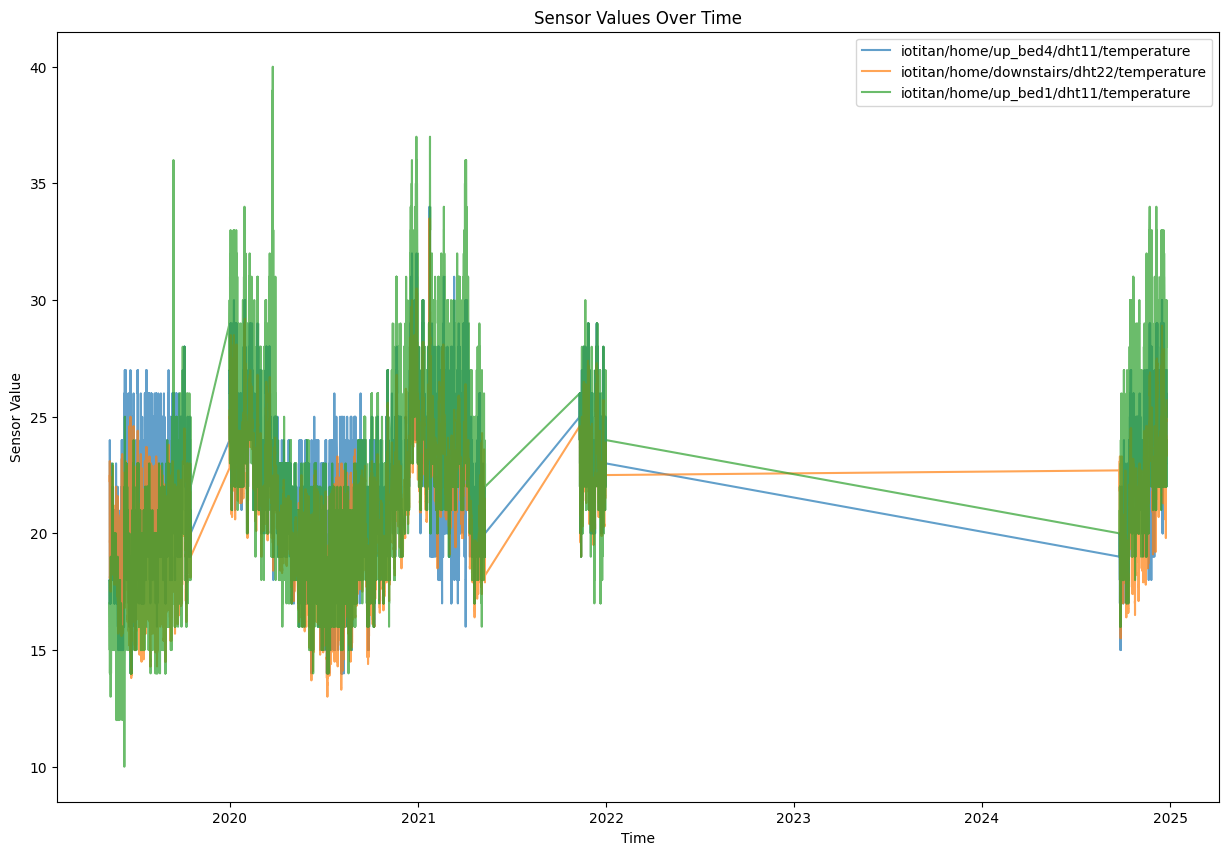

In [8]:
# Step 4: Create time series plots for each sensor
plt.figure(figsize=(15, 10))
for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        sensor_data = df[df['sensor_name'] == sensor_name]
        plt.plot(sensor_data['timestamp'], sensor_data['sensor_value'], label=sensor_name, alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.title('Sensor Values Over Time')
plt.legend()
plt.show()

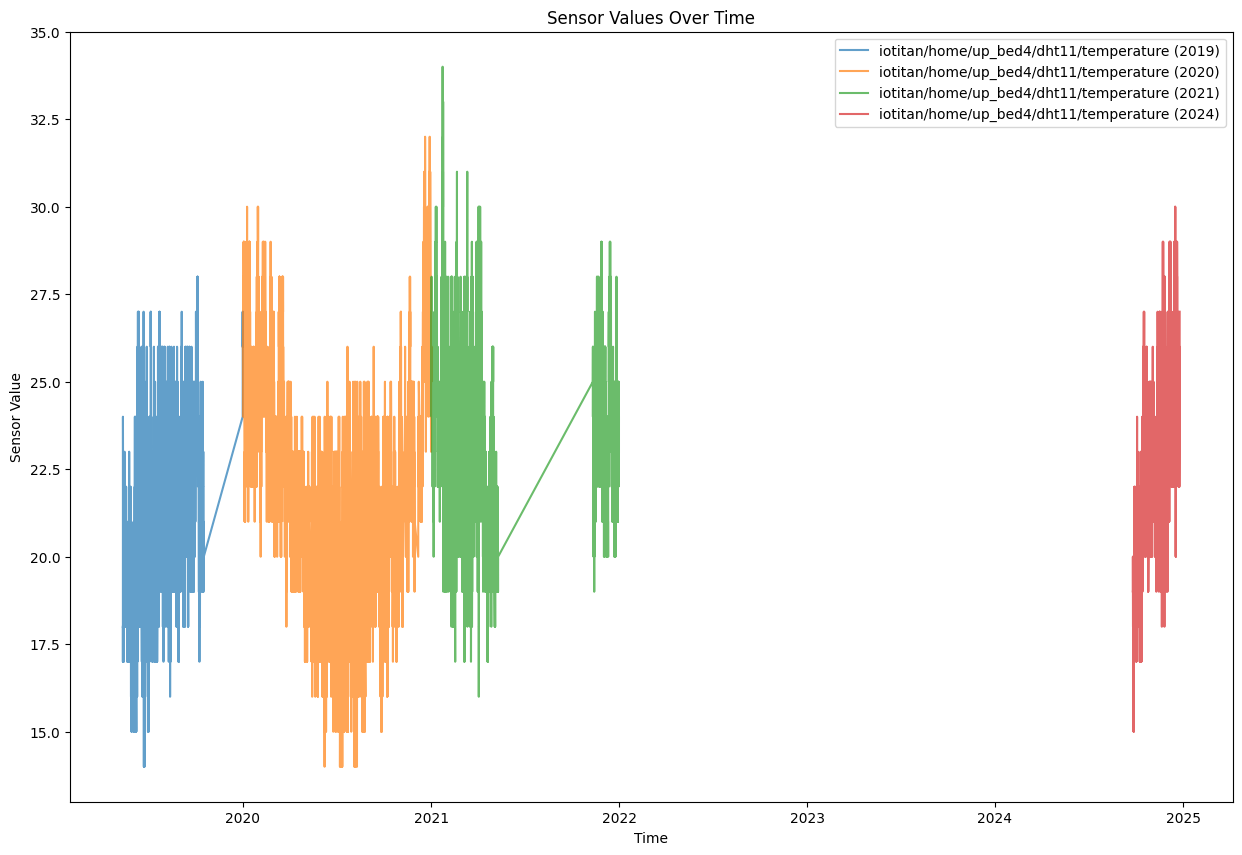

C:\Users\jon3d\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


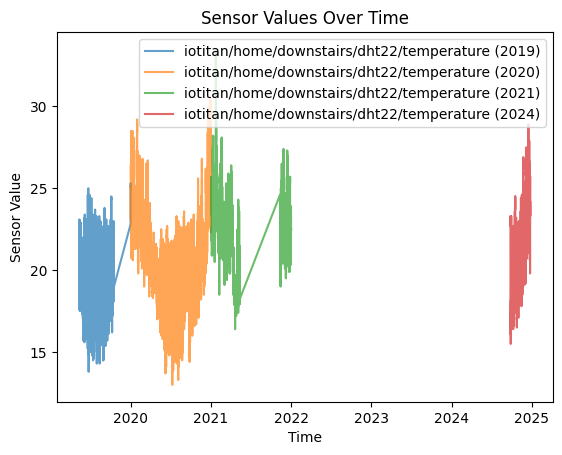

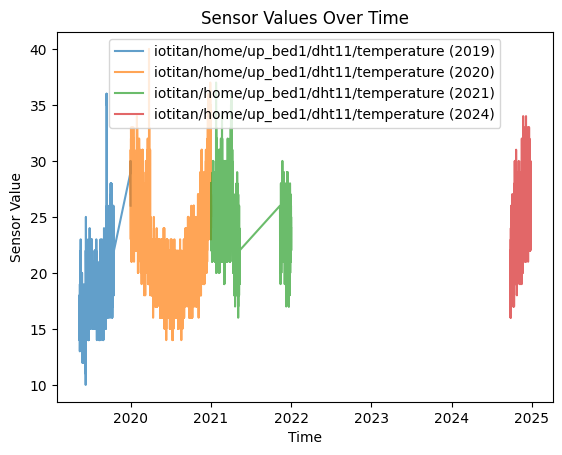

In [9]:
# Now partition the data by year
plt.figure(figsize=(15, 10))
for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        sensor_data = df[df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['timestamp'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Sensor Value')
        plt.title('Sensor Values Over Time')
        plt.legend()
        plt.show()

# MAX TEMPERATURE

In [10]:
# Create a new dataframe of max value per day for each sensor
# Step 5: Group by 'sensor_name' and 'date' and calculate the max value per day
max_per_day_df = df.groupby(['sensor_name', 'year','day_of_year'])['sensor_value'].max().reset_index()

In [11]:
#max_per_day_df['day_of_year'] = datetime.datetime(max_per_day_df['year'], max_per_day_df['month'], max_per_day_df['day']).timetuple().tm_yday
#day_of_year = datetime(YEAR, MONTH, DAY).timetuple().tm_yday

In [12]:
max_per_day_df.head(4)

,sensor_name,year,day_of_year,sensor_value
0,iotitan/home/downstairs/dht22/humidity,2019,132,58.6
1,iotitan/home/downstairs/dht22/humidity,2019,133,58.4
2,iotitan/home/downstairs/dht22/humidity,2019,134,58.9
3,iotitan/home/downstairs/dht22/humidity,2019,135,58.7


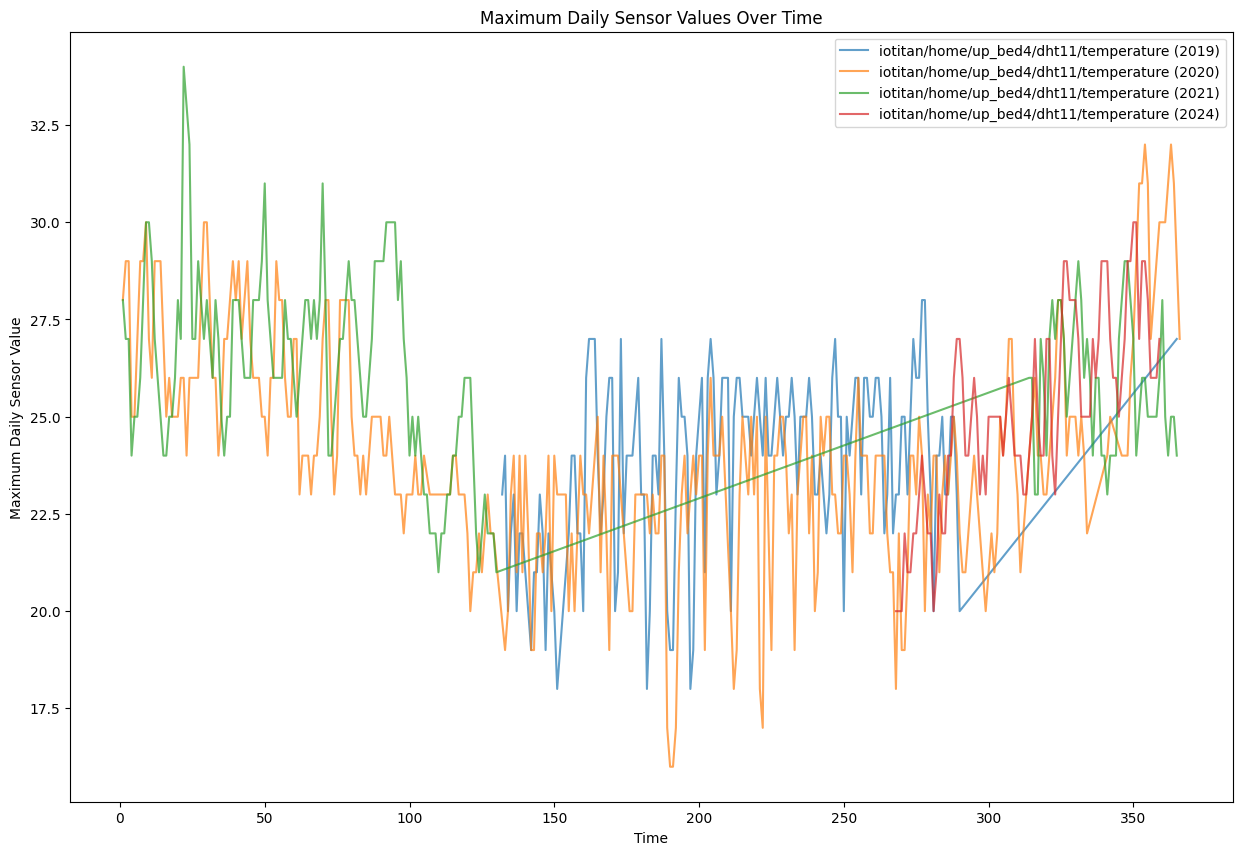

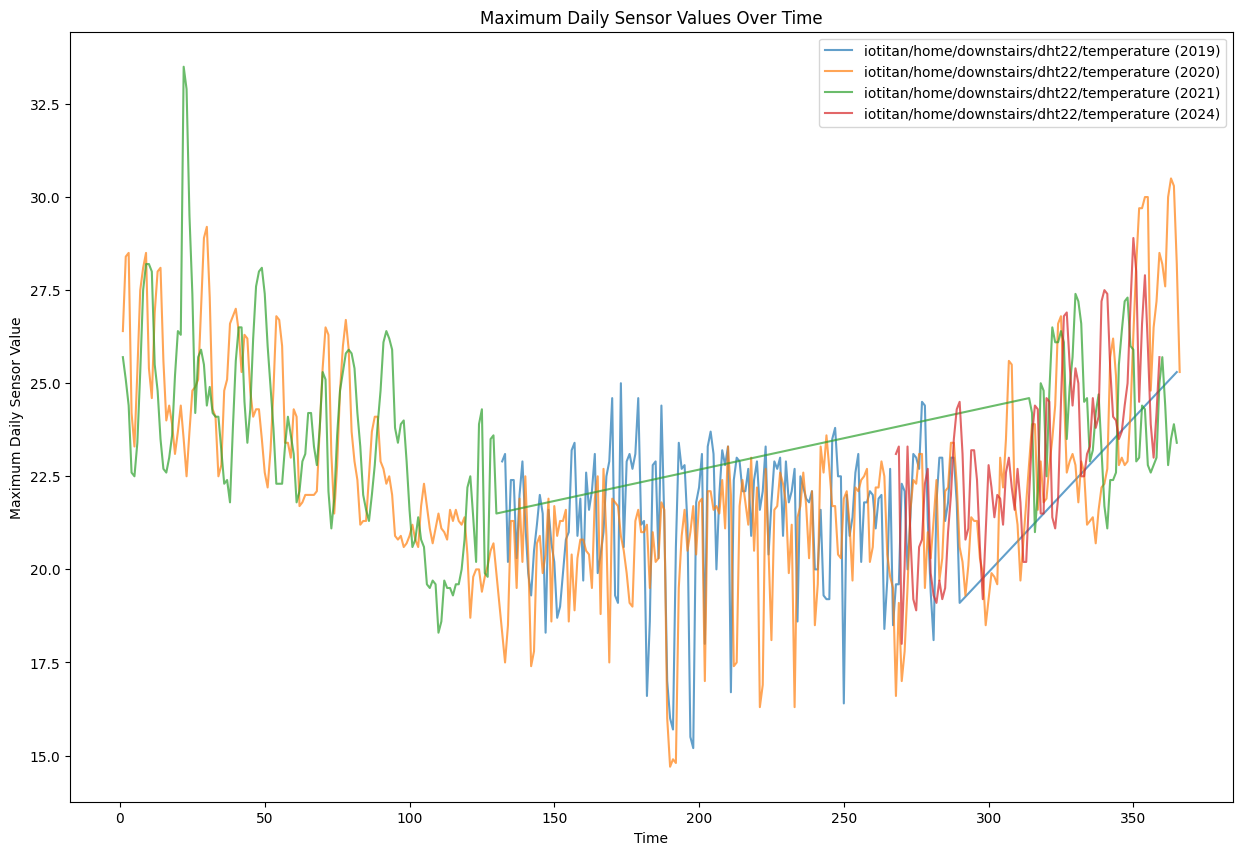

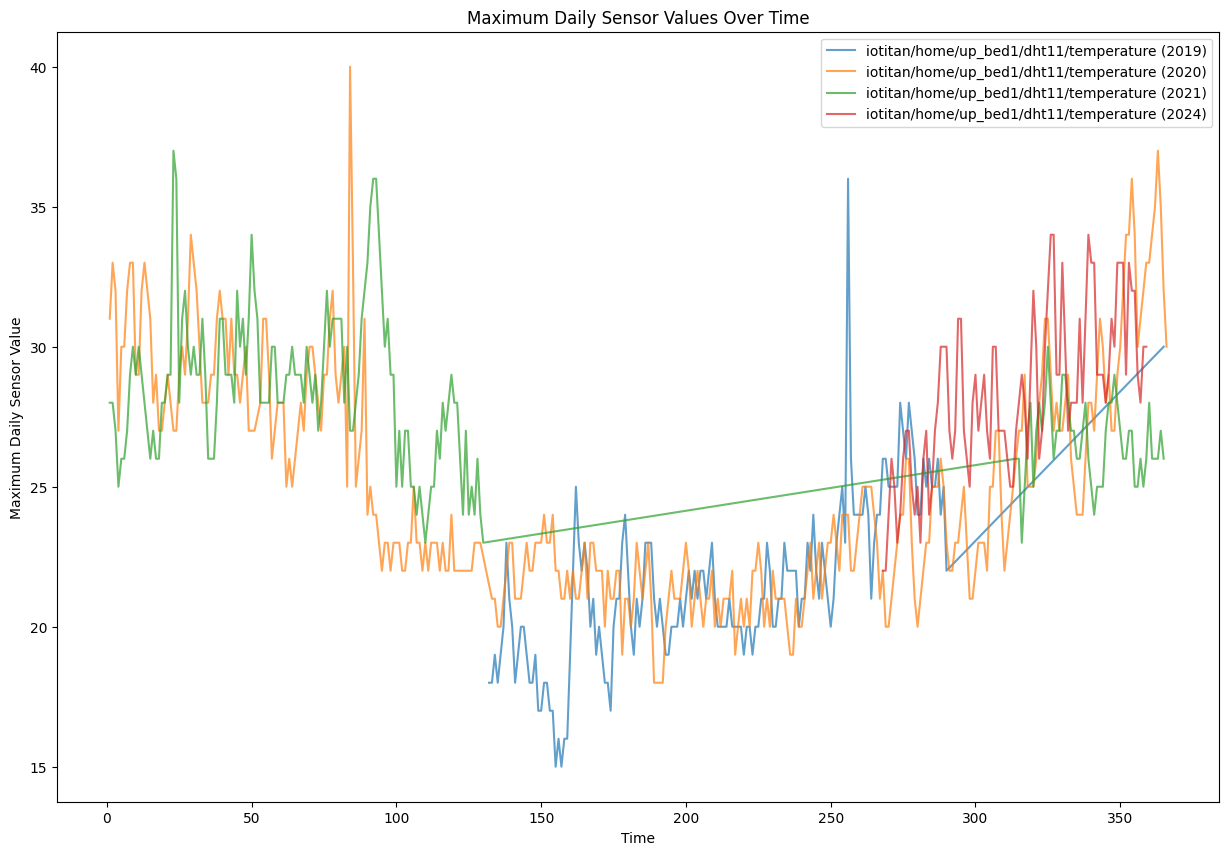

In [13]:
# Now partition the data by year


for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        plt.figure(figsize=(15, 10))
        sensor_data = max_per_day_df[max_per_day_df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['day_of_year'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Maximum Daily Sensor Value')
        plt.title('Maximum Daily Sensor Values Over Time')
        plt.legend()
        plt.show()

# SMOOTHED MAX TEMPERATURE

In [15]:
def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed


#ax.plot(x_labels, smooth(train_data, .9), label="Train Smooth")  # label="Train") # uncomment to reproduce figure below
#ax.plot(x_labels, train_data, label="Train")  # label="Train Smooth") # uncomment to reproduce figure below

In [16]:
#max_per_day_df['smoothed'] = smooth(max_per_day_df['sensor_value'], 0.9)

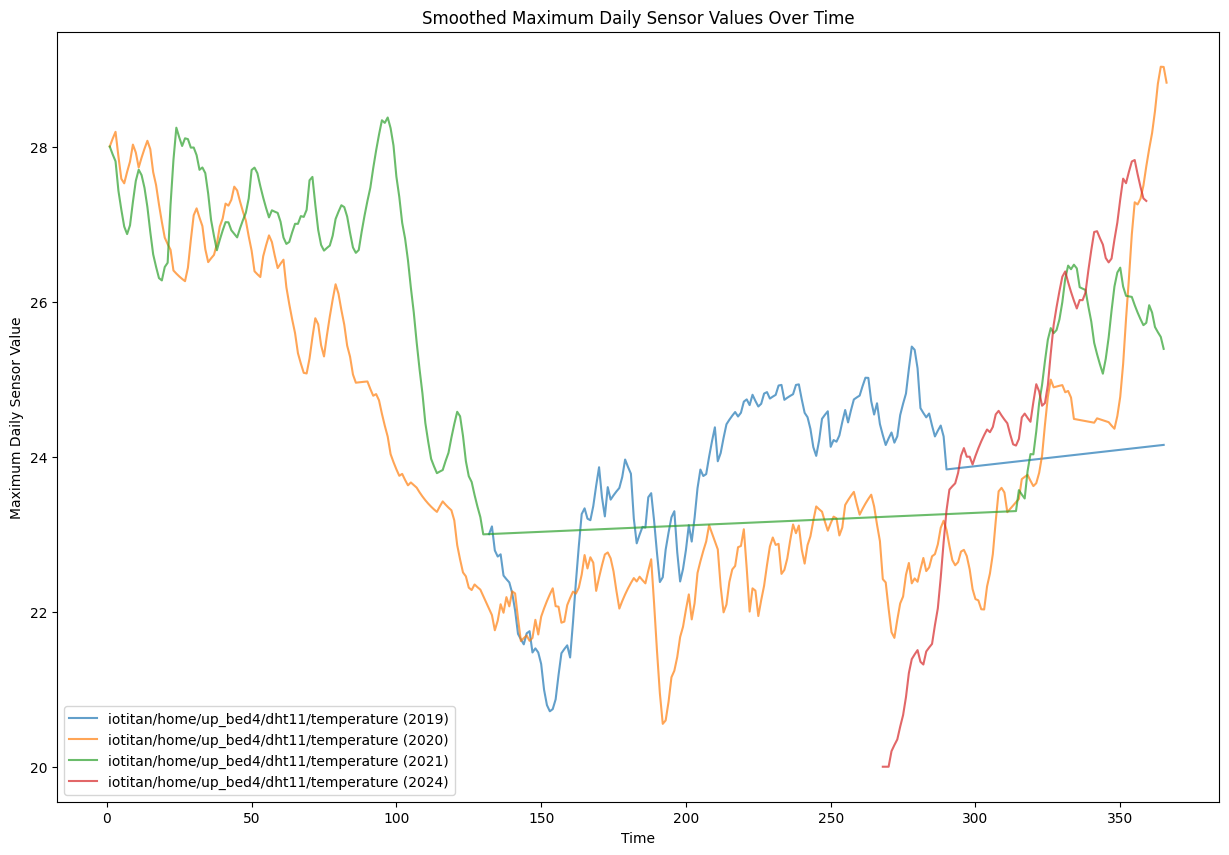

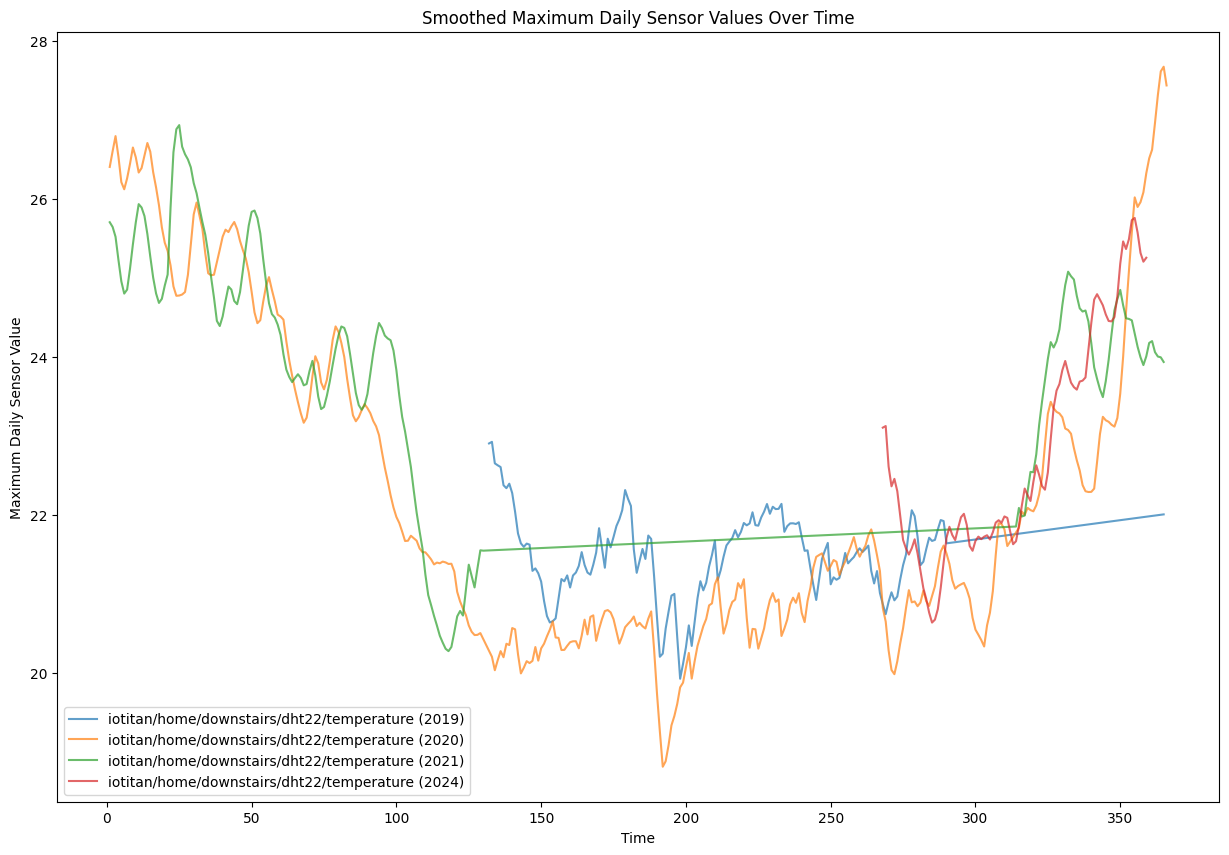

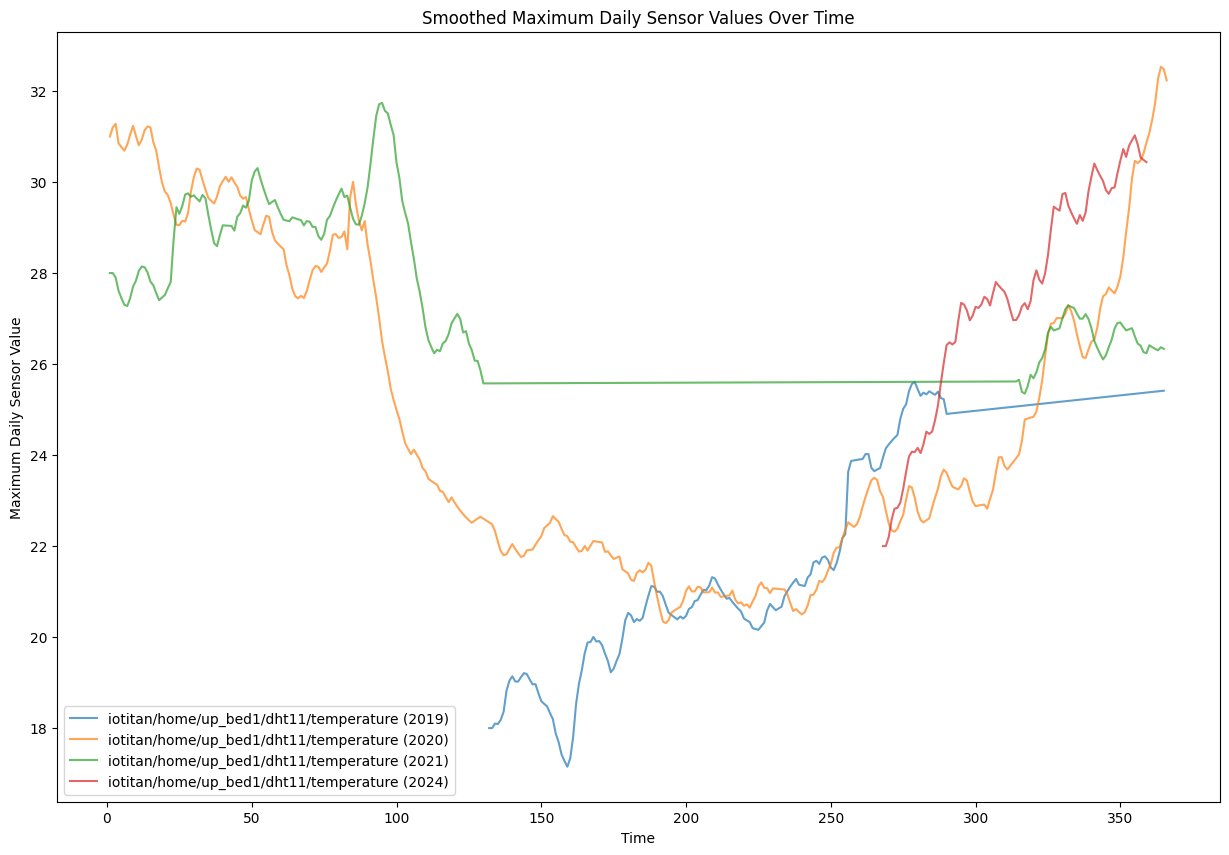

In [17]:
for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        plt.figure(figsize=(15, 10))
        sensor_data = max_per_day_df[max_per_day_df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            year_values_ordered = year_data.sort_values(by=['day_of_year'], ascending=True)['sensor_value'].to_list()
            year_values_smoothed = smooth(year_values_ordered, 0.9)
            plt.plot(year_data['day_of_year'], year_values_smoothed, label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Maximum Daily Sensor Value')
        plt.title('Smoothed Maximum Daily Sensor Values Over Time')
        plt.legend()
        plt.show()

# MIN TEMPERATURE

In [18]:
# Create a new dataframe of min value per day for each sensor
# Step 5: Group by 'sensor_name' and 'date' and calculate the max value per day
min_per_day_df = df.groupby(['sensor_name', 'year','day_of_year'])['sensor_value'].min().reset_index()

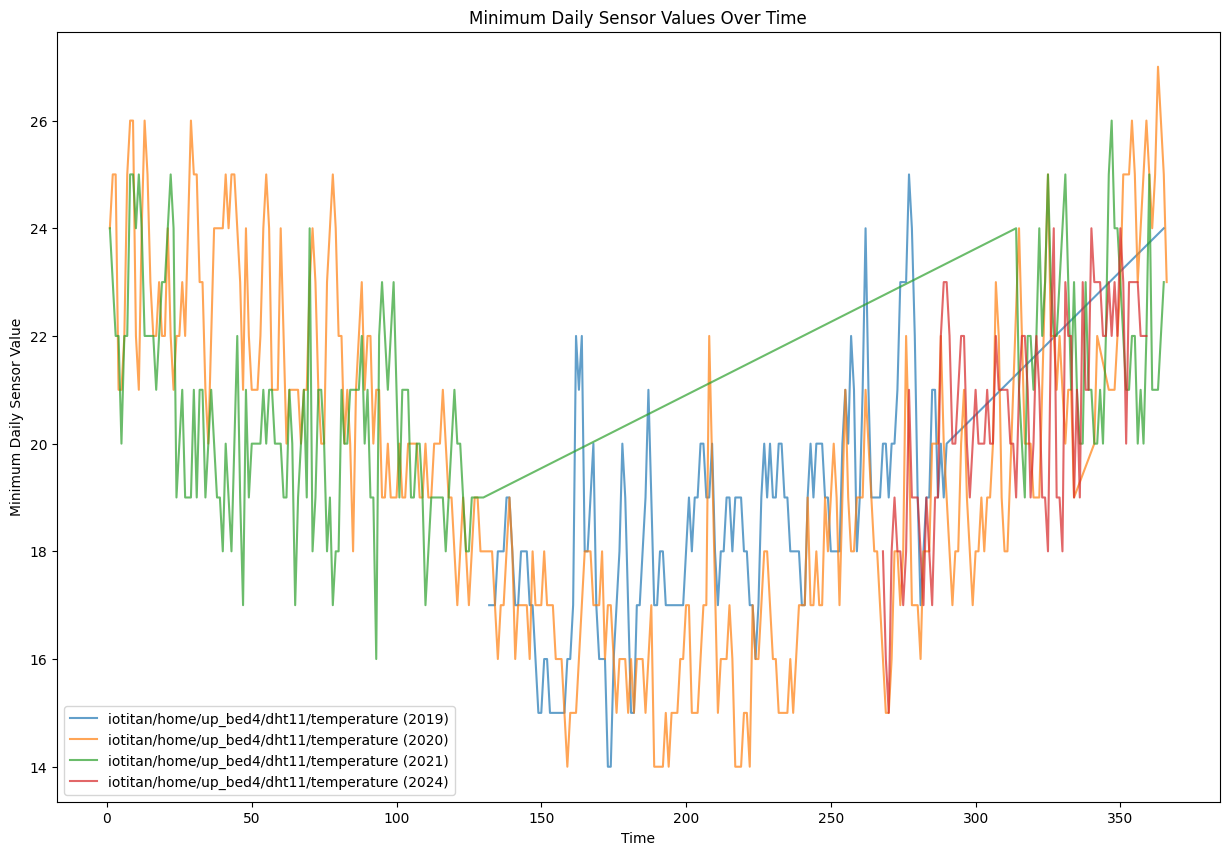

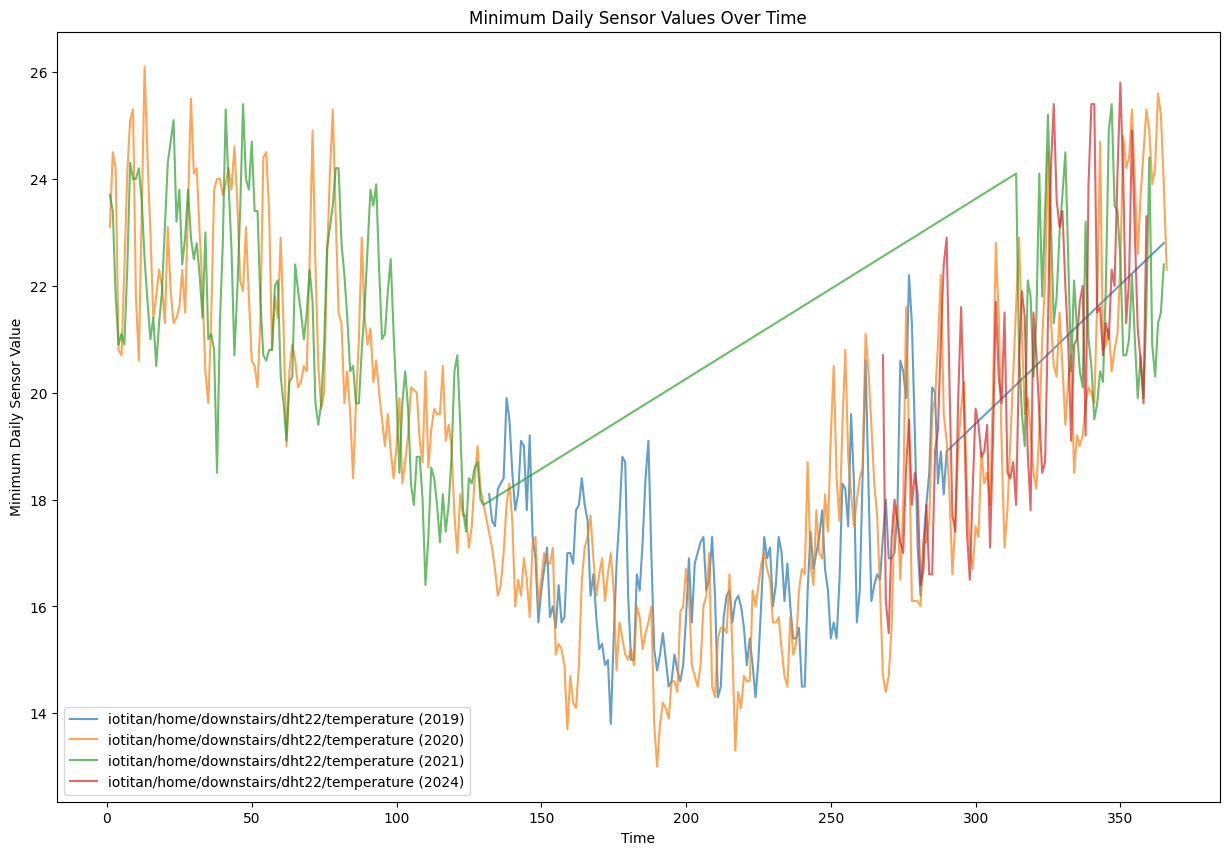

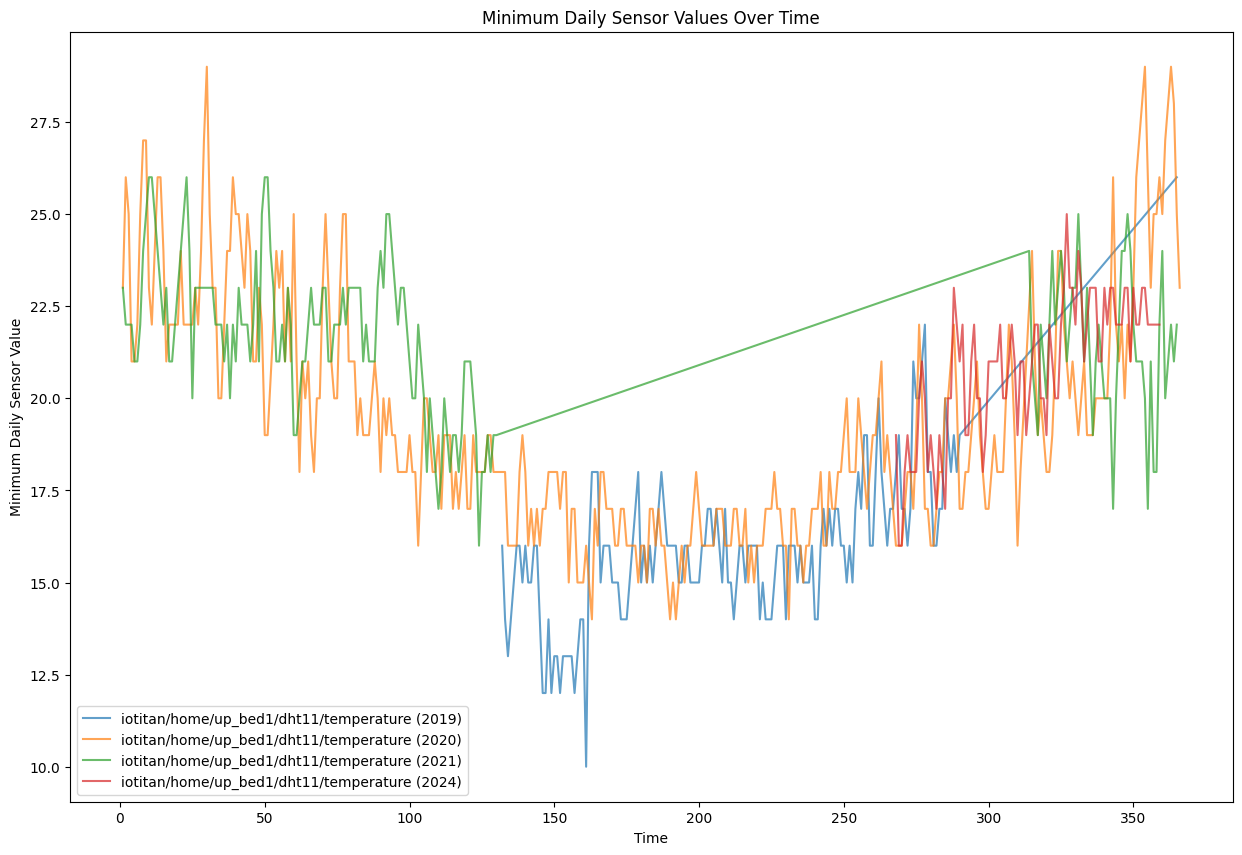

In [19]:
# Now partition the data by year
for sensor_name in sensor_names:
    if ('temperature' in sensor_name) and ('average' not in sensor_name):
        plt.figure(figsize=(15, 10))
        sensor_data = min_per_day_df[min_per_day_df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['day_of_year'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Minimum Daily Sensor Value')
        plt.title('Minimum Daily Sensor Values Over Time')
        plt.legend()
        plt.show()

# Radmon count per minute

iotitan/home/outside/radmon/cpm

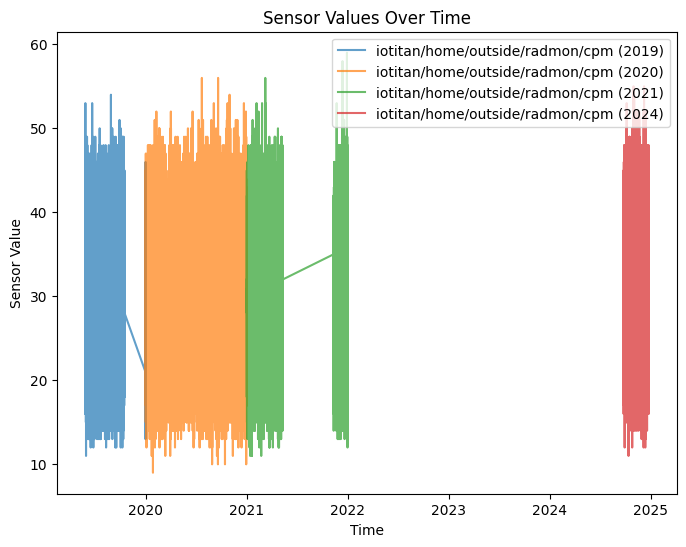

In [20]:
# Now partition the data by year
plt.figure(figsize=(8, 6))
for sensor_name in sensor_names:
    if (sensor_name == 'iotitan/home/outside/radmon/cpm'):
        sensor_data = df[df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['timestamp'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Sensor Value')
        plt.title('Sensor Values Over Time')
        plt.legend()
        plt.show()

C:\Users\jon3d\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


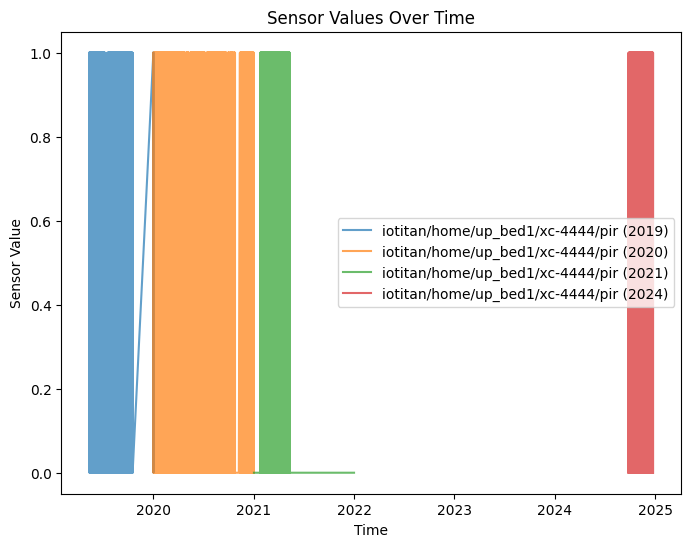

In [21]:
# Now partition the data by year
plt.figure(figsize=(8, 6))
for sensor_name in sensor_names:
    if (sensor_name == 'iotitan/home/up_bed1/xc-4444/pir'):
        sensor_data = df[df['sensor_name'] == sensor_name]
        years = sensor_data['year'].unique()
        for year in years:
            year_data = sensor_data[sensor_data['year'] == year]
            plt.plot(year_data['timestamp'], year_data['sensor_value'], label=f"{sensor_name} ({year})", alpha=0.7)

        plt.xlabel('Time')
        plt.ylabel('Sensor Value')
        plt.title('Sensor Values Over Time')
        plt.legend()
        plt.show()

# Hypothesis Test
Compare 3 months of 2024 data to the same day_of_year from 2020.  We want to test whether our house upgrades have improved the inside temperatures. The null hypothesis is therefore "no effect", i.e. 2020 and 2024 temperatures belong to the same distribution

In [22]:
# Step 5: Filter data for the year 2024
data_2024 = df[df['year'] == 2024]

# Step 6: Filter data for the year 2020 with the same 'day_of_year' as the 2024 data
data_2020 = df[(df['year'] == 2020) & (df['day_of_year'].isin(data_2024['day_of_year']))]

# Step 7: Perform a hypothesis test (Kolmogorov-Smirnov test) for each sensor
sensor_names = data_2024['sensor_name'].unique()
results = []

for sensor_name in sensor_names:
    sensor_data_2024 = data_2024[data_2024['sensor_name'] == sensor_name]['sensor_value']
    sensor_data_2020 = data_2020[data_2020['sensor_name'] == sensor_name]['sensor_value']

    #Perform a Hypothesis Test:
    #For each sensor, get the sensor_value data for 2024 and 2020.
    #Perform the Kolmogorov-Smirnov test using ks_2samp to compare the distributions.
    #Store the results (sensor name, KS statistic, and p-value) in a list.
    if not sensor_data_2024.empty and not sensor_data_2020.empty:
        ks_stat, p_value = ks_2samp(sensor_data_2024, sensor_data_2020)
        results.append({'sensor_name': sensor_name, 'ks_stat': ks_stat, 'p_value': p_value})

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

                                          sensor_name   ks_stat        p_value
0              iotitan/home/downstairs/dht22/humidity  0.176359   0.000000e+00
1           iotitan/home/downstairs/dht22/temperature  0.110654   0.000000e+00
2                    iotitan/home/up_bed1/xc-4444/pir  0.012597  1.123606e-104
3                 iotitan/home/up_bed4/dht11/humidity  0.245389   0.000000e+00
4              iotitan/home/up_bed4/dht11/temperature  0.196316   0.000000e+00
5                 iotitan/home/up_bed1/dht11/humidity  0.117619   0.000000e+00
6              iotitan/home/up_bed1/dht11/temperature  0.261324   0.000000e+00
7      iotitan/home/downstairs/dht22/humidity/average  0.176175   0.000000e+00
8   iotitan/home/downstairs/dht22/temperature/average  0.112080  3.629669e-141
9             iotitan/home/outside/radmon/cpm/average  0.096836  1.173204e-102
10           iotitan/home/outside/radmon/dose/average  0.094529   7.795556e-98
11           iotitan/home/outside/radmon/rssi/averag

so we reject the null hypothesis.  All 2024 results are drawn from a different distribution to the 2020 results

In [23]:
# Step 5: Filter data for the year 2024
max_data_2024 = max_per_day_df[max_per_day_df['year'] == 2024]

# Step 6: Filter data for the year 2020 with the same 'day_of_year' as the 2024 data
max_data_2020 = max_per_day_df[(max_per_day_df['year'] == 2020) & (max_per_day_df['day_of_year'].isin(max_data_2024['day_of_year']))]

# Step 7: Perform a hypothesis test (Kolmogorov-Smirnov test) for each sensor
sensor_names = ['iotitan/home/downstairs/dht22/temperature', 'iotitan/home/up_bed4/dht11/temperature','iotitan/home/up_bed4/dht11/temperature']
results = []

for sensor_name in sensor_names:
    sensor_data_2024 = max_data_2024[max_data_2024['sensor_name'] == sensor_name]['sensor_value']
    sensor_data_2020 = max_data_2020[max_data_2020['sensor_name'] == sensor_name]['sensor_value']

    #Perform a Hypothesis Test:
    #For each sensor, get the sensor_value data for 2024 and 2020.
    #Perform the Kolmogorov-Smirnov test using ks_2samp to compare the distributions.
    #Store the results (sensor name, KS statistic, and p-value) in a list.
    if not sensor_data_2024.empty and not sensor_data_2020.empty:
        ks_stat, p_value = ks_2samp(sensor_data_2024, sensor_data_2020)
        results.append({'sensor_name': sensor_name, 'ks_stat': ks_stat, 'p_value': p_value})

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

                                 sensor_name   ks_stat   p_value
0  iotitan/home/downstairs/dht22/temperature  0.175256  0.106008
1     iotitan/home/up_bed4/dht11/temperature  0.246196  0.008845
2     iotitan/home/up_bed4/dht11/temperature  0.246196  0.008845


So the null hypothesis for the max daily temperature recorded by the downstairs sensor is true.  2020 is the same as 2024.

In [24]:
max_data_2024.head(5)

,sensor_name,year,day_of_year,sensor_value
701,iotitan/home/downstairs/dht22/humidity,2024,268,50.4
702,iotitan/home/downstairs/dht22/humidity,2024,269,48.9
703,iotitan/home/downstairs/dht22/humidity,2024,270,50.8
704,iotitan/home/downstairs/dht22/humidity,2024,271,56.8
705,iotitan/home/downstairs/dht22/humidity,2024,272,66.9


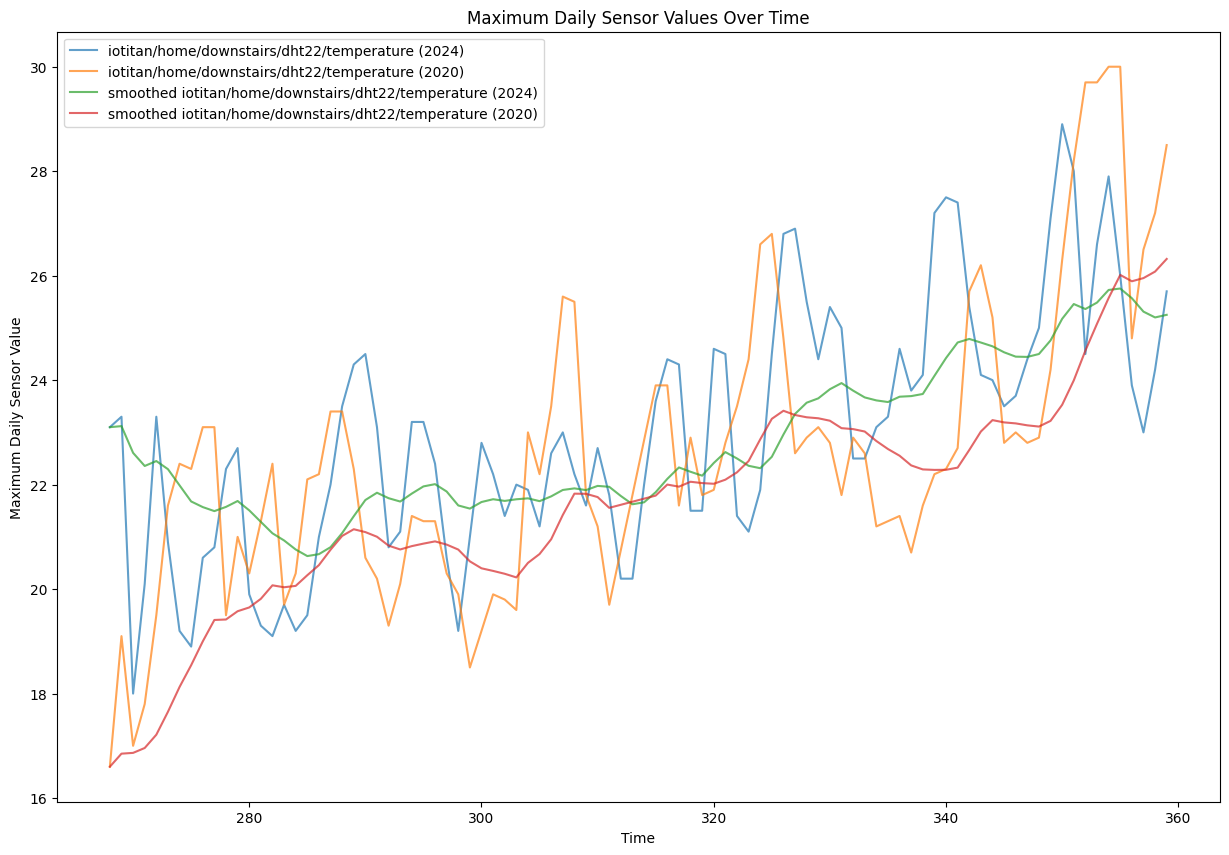

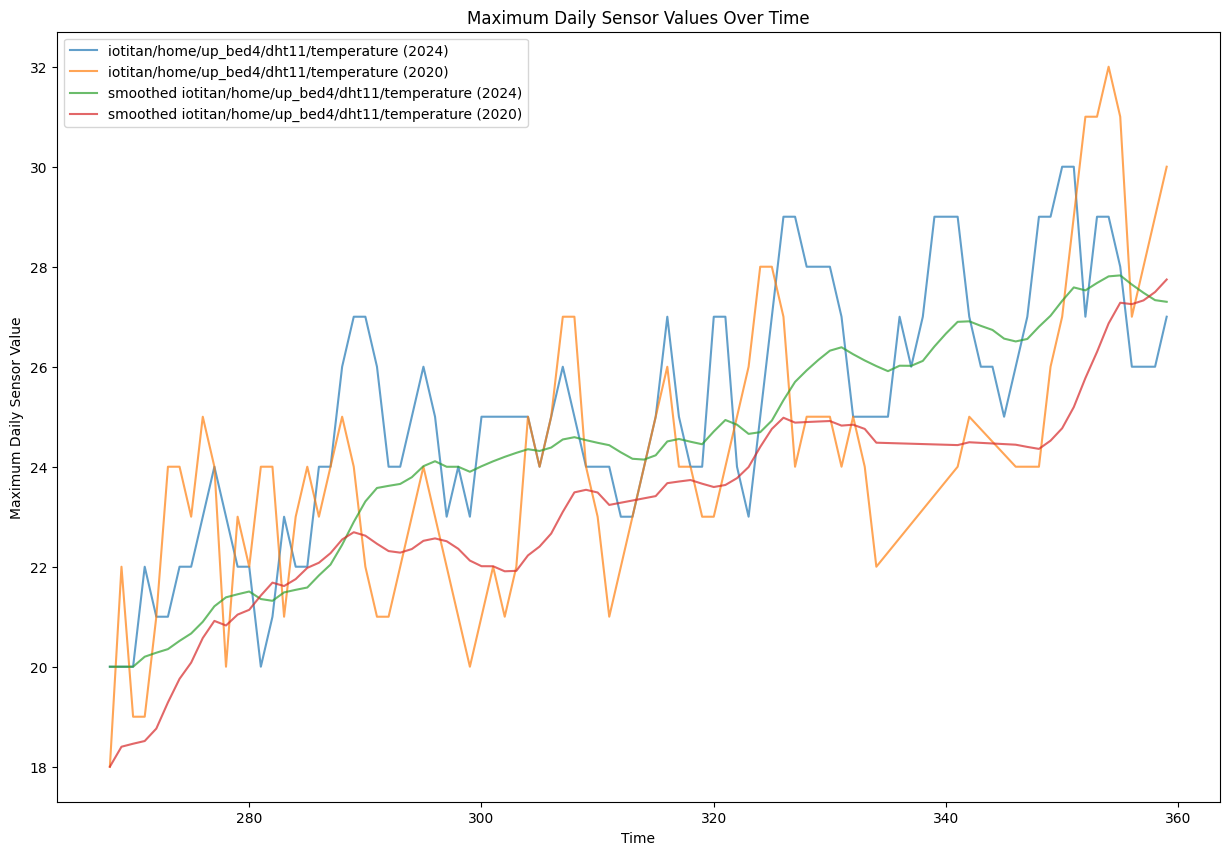

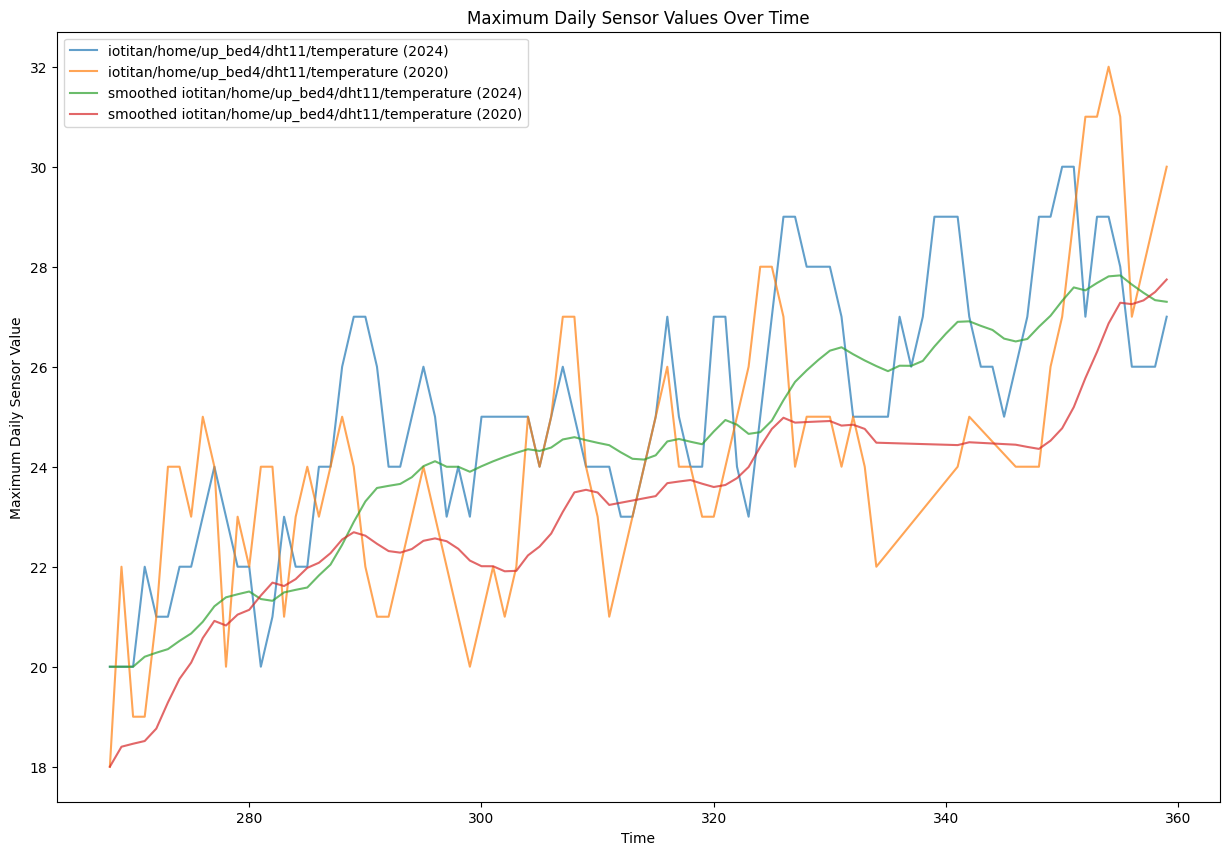

In [32]:
# Following plots do not show any visually observable difference between the max daily temps in 2020 vs 2024
for sensor_name in sensor_names:
    plt.figure(figsize=(15, 10))
    sensor_data_2024 = max_data_2024[max_data_2024['sensor_name'] == sensor_name]
    sensor_data_2020 = max_data_2020[max_data_2020['sensor_name'] == sensor_name]
    ordered_2020 = sensor_data_2020.sort_values(by=['day_of_year'], ascending=True)['sensor_value'].to_list()
    ordered_2024 = sensor_data_2024.sort_values(by=['day_of_year'], ascending=True)['sensor_value'].to_list()
    smoothed_2020 = smooth(ordered_2020, 0.9)
    smoothed_2024 = smooth(ordered_2024, 0.9)
    plt.plot(sensor_data_2024['day_of_year'], sensor_data_2024['sensor_value'], label=f"{sensor_name} (2024)", alpha=0.7)
    plt.plot(sensor_data_2020['day_of_year'], sensor_data_2020['sensor_value'], label=f"{sensor_name} (2020)", alpha=0.7)
    plt.plot(sensor_data_2024['day_of_year'], smoothed_2024, label=f"smoothed {sensor_name} (2024)", alpha=0.7)
    plt.plot(sensor_data_2020['day_of_year'], smoothed_2020, label=f"smoothed {sensor_name} (2020)", alpha=0.7)

    plt.xlabel('Time')
    plt.ylabel('Maximum Daily Sensor Value')
    plt.title('Maximum Daily Sensor Values Over Time')
    plt.legend()
    plt.show()

In [26]:
# Create a new dataframe of average value per day for each sensor
# Step 5: Group by 'sensor_name' and 'date' and calculate the max value per day
avg_per_day_df = df.groupby(['sensor_name', 'year','day_of_year'])['sensor_value'].mean().reset_index()

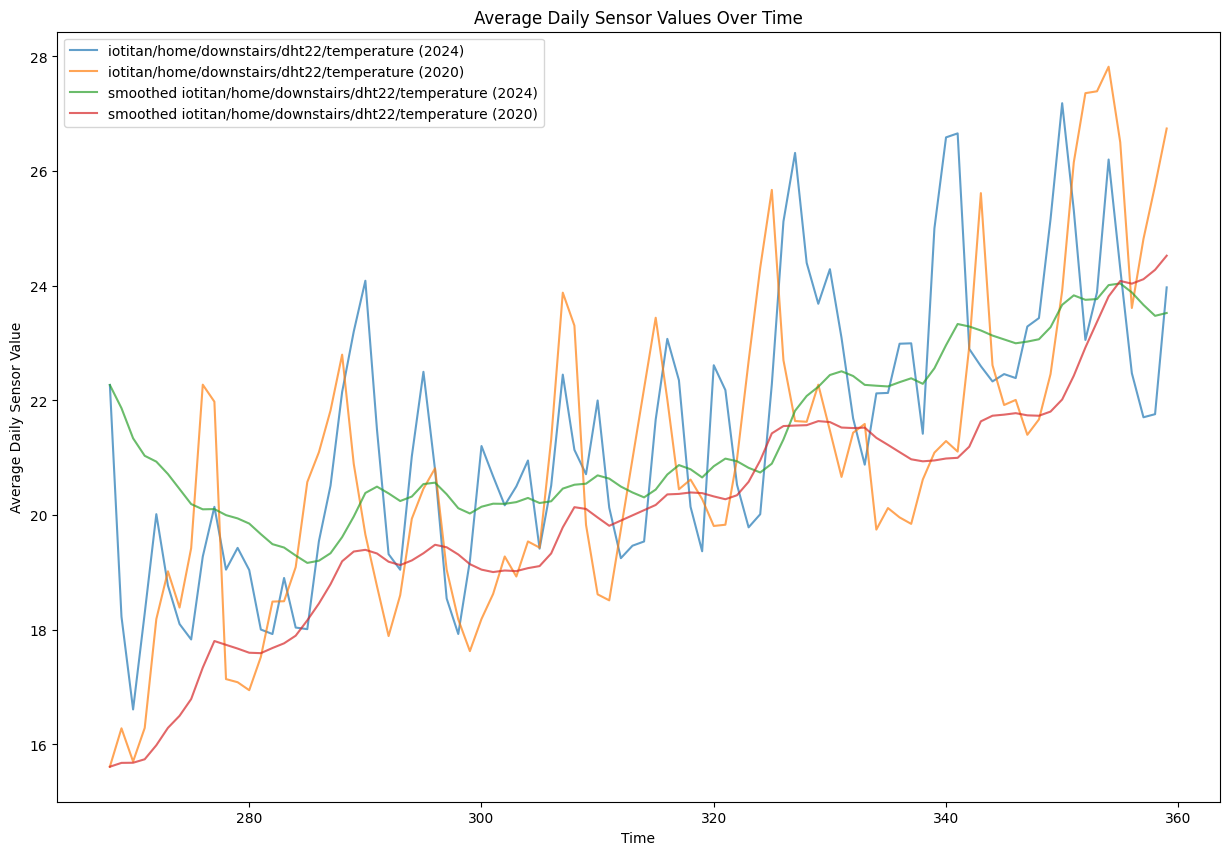

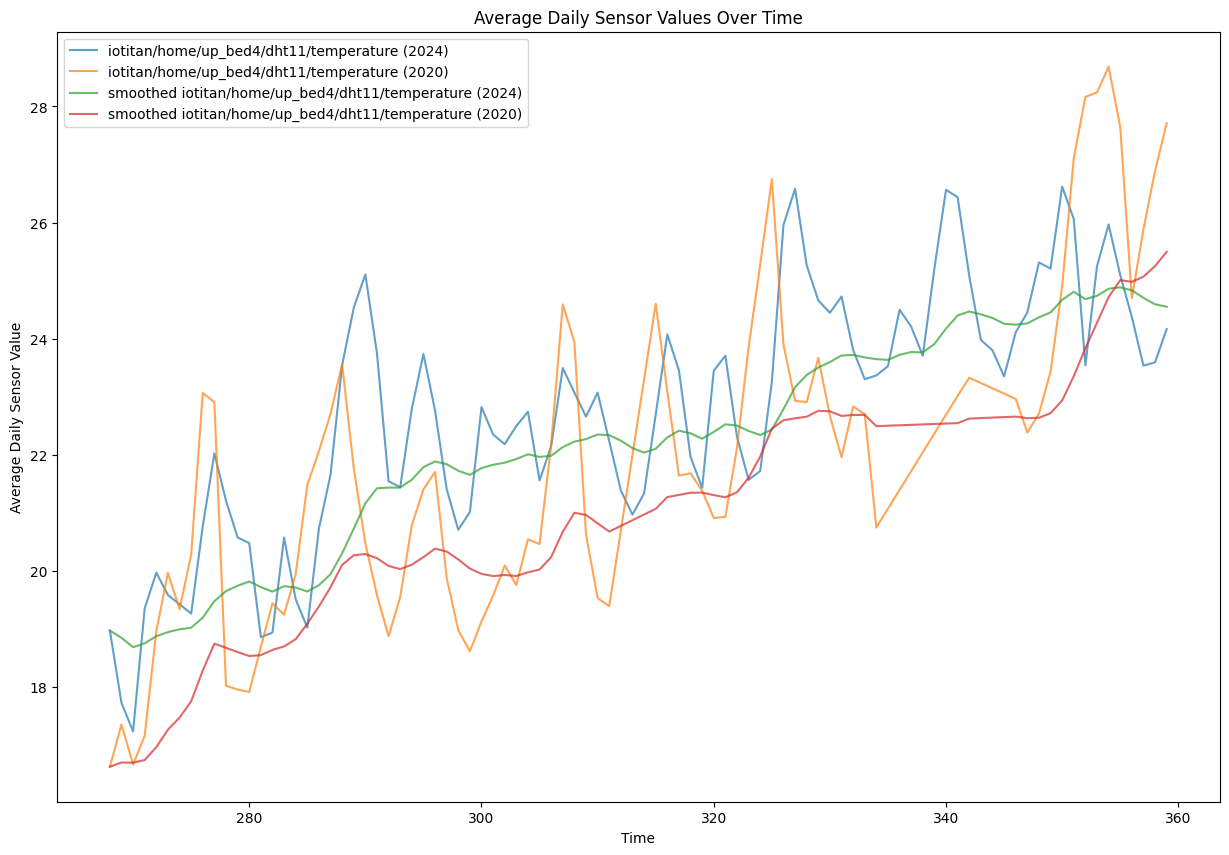

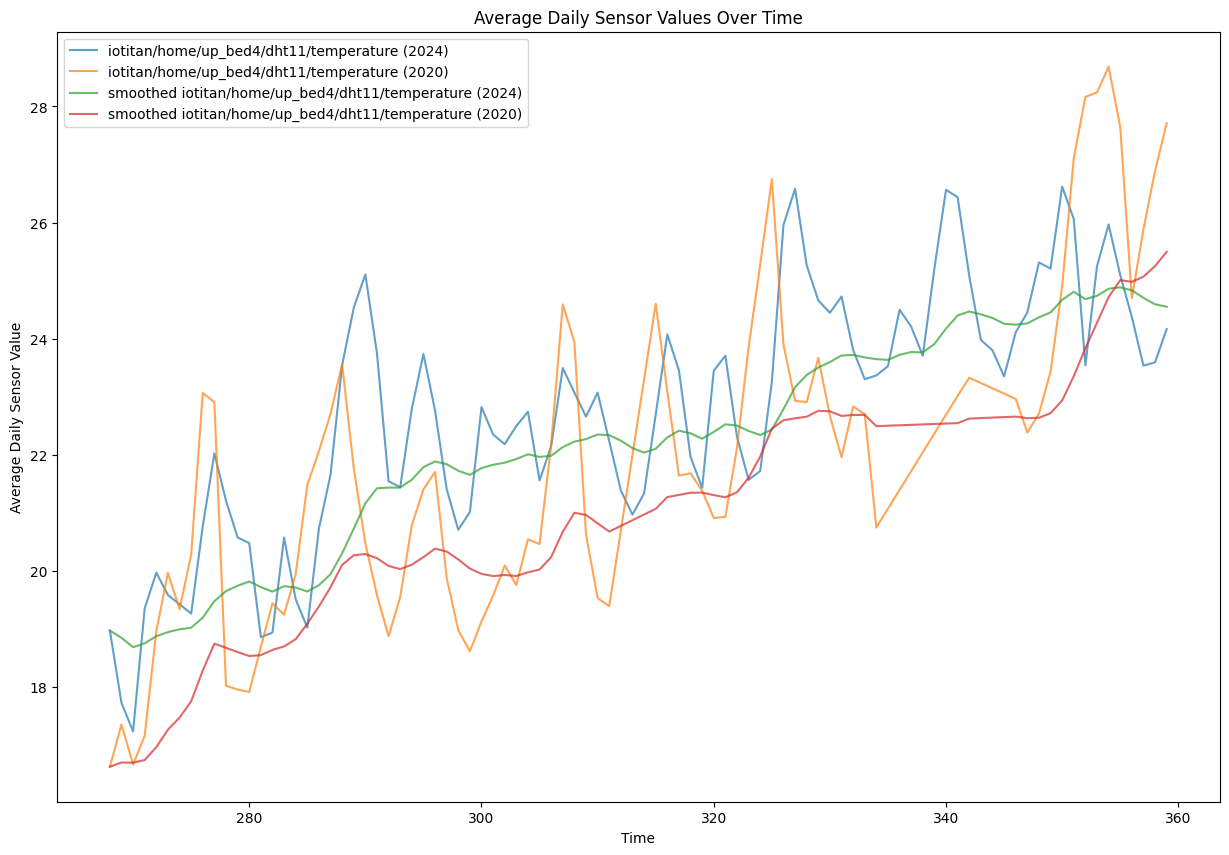

In [31]:
# Step 5: Filter data for the year 2024
avg_data_2024 = avg_per_day_df[avg_per_day_df['year'] == 2024]

# Step 6: Filter data for the year 2020 with the same 'day_of_year' as the 2024 data
avg_data_2020 = avg_per_day_df[(avg_per_day_df['year'] == 2020) & (avg_per_day_df['day_of_year'].isin(avg_data_2024['day_of_year']))]

sensor_names = ['iotitan/home/downstairs/dht22/temperature', 'iotitan/home/up_bed4/dht11/temperature','iotitan/home/up_bed4/dht11/temperature']
results = []

for sensor_name in sensor_names:
    plt.figure(figsize=(15, 10))
    sensor_data_2024 = avg_data_2024[avg_data_2024['sensor_name'] == sensor_name]
    sensor_data_2020 = avg_data_2020[avg_data_2020['sensor_name'] == sensor_name]
    
    ordered_2020 = sensor_data_2020.sort_values(by=['day_of_year'], ascending=True)['sensor_value'].to_list()
    ordered_2024 = sensor_data_2024.sort_values(by=['day_of_year'], ascending=True)['sensor_value'].to_list()
    smoothed_2020 = smooth(ordered_2020, 0.9)
    smoothed_2024 = smooth(ordered_2024, 0.9)
    plt.plot(sensor_data_2024['day_of_year'], sensor_data_2024['sensor_value'], label=f"{sensor_name} (2024)", alpha=0.7)
    plt.plot(sensor_data_2020['day_of_year'], sensor_data_2020['sensor_value'], label=f"{sensor_name} (2020)", alpha=0.7)
    plt.plot(sensor_data_2024['day_of_year'], smoothed_2024, label=f"smoothed {sensor_name} (2024)", alpha=0.7)
    plt.plot(sensor_data_2020['day_of_year'], smoothed_2020, label=f"smoothed {sensor_name} (2020)", alpha=0.7)

    plt.xlabel('Time')
    plt.ylabel('Average Daily Sensor Value')
    plt.title('Average Daily Sensor Values Over Time')
    plt.legend()
    plt.show()


So it looks like the 2024 numbers have less variance in the max and avg temperatures (at least for upstairs)

We could also measure distance to optimum temperature of 23 degrees.  Perhaps the 2024 temperatures are closer to ideal?

I am unsure where the sensors were placed in 2020.  Is there a way to get 2022 and 2023 data from Thingspeak?
ANSWER:  Yes, thingspeak.com is still logging all my data.  For channel "IoTitan Home" 752701 I exported all the data using their web interface.  It contains data from 2019 to 2024!
Now analyse that data.
